# Домашнее задание 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import requests
%matplotlib inline
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import powerlaw
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 22
sns.set_style("whitegrid") 

In [2]:
def load_url_content_to_file(url: str, filename: str):
    response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(response.content)

## 1. Рост сети цитирований (8 баллов)

Для данных известно время появления каждой вершины (статьи). Рассмотрим рост сети цитирований, считая за единицу времени 1 месяц, т.е. за один шаг к существующей сети добавляются вершины одного месяца, далее - следующего и т.д.

* Постройте зависимость степени вершины от времени для нескольких "старых" вершин. Какому закону подчиняется рост сети?

* вычислите прирост степени за единицу времени $\Delta k_i$ для каждой текущей вершины $i$ времени $t$ как изменение степени за 1 месяц.
Определите суммарное изменение степеней вершин $\pi (k)=\sum_{k_i}\Delta k_i$ (кумулятивное распределение прироста степени), и $k=max (k_i)$ (по значениям начального месяца);
*  постройте зависимость $\pi (k)$ и аппроксимируйте ее степенной функцией. Можно ли считать, что сеть растет по принципу предпочтительного присоединения? Определите тип присоединения.

In [3]:
load_url_content_to_file(
    url="https://drive.google.com/uc?id=1vIbbqxDx7Y1nYfE8pAx-eLtbhSokSu6V",
    filename = "Cit-HepPh.txt"
)

In [4]:
G = nx.read_edgelist("Cit-HepPh.txt",nodetype=int)
print('Nodes:',G.number_of_nodes()) # и выводим основные свойства
print('Edges:',G.number_of_edges())
print('Density:',nx.density(G))

Nodes: 34546
Edges: 420921
Density: 0.0007054197642773696


In [5]:
load_url_content_to_file(
    url="https://drive.google.com/uc?id=1G4SOy6ltn_gwiSOCUiZ5ZBrEeA0p0y77",
    filename = "cit-HepPh-dates.txt"
)

In [6]:
data=pd.read_csv('cit-HepPh-dates.txt', sep='\t')
data.head(5)

,# cross-listed papers have ids 11<true_id>
9203201,1992-02-24
9203202,1992-03-08
9203203,1992-03-03
9203204,1992-03-09
9203205,1992-03-09


In [7]:
nodes_df = data.reset_index()
nodes_df.columns = ['node_id', 'date']
nodes_df['date'] = pd.to_datetime(
    nodes_df['date']
).dt.to_period('M').dt.to_timestamp().dt.date
nodes_df

,node_id,date
0,9203201,1992-02-01
1,9203202,1992-03-01
2,9203203,1992-03-01
3,9203204,1992-03-01
4,9203205,1992-03-01
...,...,...
38552,11203032,2002-03-01
38553,11203009,2002-03-01
38554,11203005,2002-03-01
38555,11203090,2002-03-01


* Постройте зависимость степени вершины от времени для нескольких "старых" вершин. Какому закону подчиняется рост сети?

* вычислите прирост степени за единицу времени $\Delta k_i$ для каждой текущей вершины $i$ времени $t$ как изменение степени за 1 месяц.
Определите суммарное изменение степеней вершин $\pi (k)=\sum_{k_i}\Delta k_i$ (кумулятивное распределение прироста степени), и $k=max (k_i)$ (по значениям начального месяца);

In [8]:
np.random.seed(42)

old_date = nodes_df["date"].min()

old_nodes = nodes_df[nodes_df["date"] == old_date]["node_id"]
dates = nodes_df[nodes_df["date"] != old_date]["date"].drop_duplicates().sort_values()

In [9]:
old_nodes

0      9203201
563    9211202
Name: node_id, dtype: int64

In [10]:
num_old_nodes = len(old_nodes)
g_degrees = []

for date in dates:
    curr_nodes = nodes_df[nodes_df["date"]<date]["node_id"]
    new_nodes = nodes_df[nodes_df["date"]==date]["node_id"]
    curr_graph = G.subgraph(curr_nodes)    
    for node_id in old_nodes:
        degrees_row = {}
        degrees_row["date"] = date
        degrees_row["node_id"] = node_id
        degrees_row["degree"] = len(curr_graph.edges(node_id)) if node_id in curr_graph else 0
        g_degrees.append(degrees_row)
degrees_df = pd.DataFrame(g_degrees)
degrees_df

,date,node_id,degree
0,1992-03-01,9203201,0
1,1992-03-01,9211202,0
2,1992-04-01,9203201,0
3,1992-04-01,9211202,0
4,1992-05-01,9203201,0
...,...,...,...
237,2002-01-01,9211202,24
238,2002-02-01,9203201,81
239,2002-02-01,9211202,24
240,2002-03-01,9203201,81


In [11]:
degrees_df["degree_lag"] = degrees_df['degree'].shift(num_old_nodes-1).fillna(degrees_df["degree"][0])
degrees_df["mean"] = degrees_df[["degree_lag", "degree"]].mean(axis=1)
degrees_df["max"] = degrees_df[["degree_lag", "degree"]].max(axis=1)

<Axes: title={'center': 'Среднее степеней вершин'}, xlabel='date'>

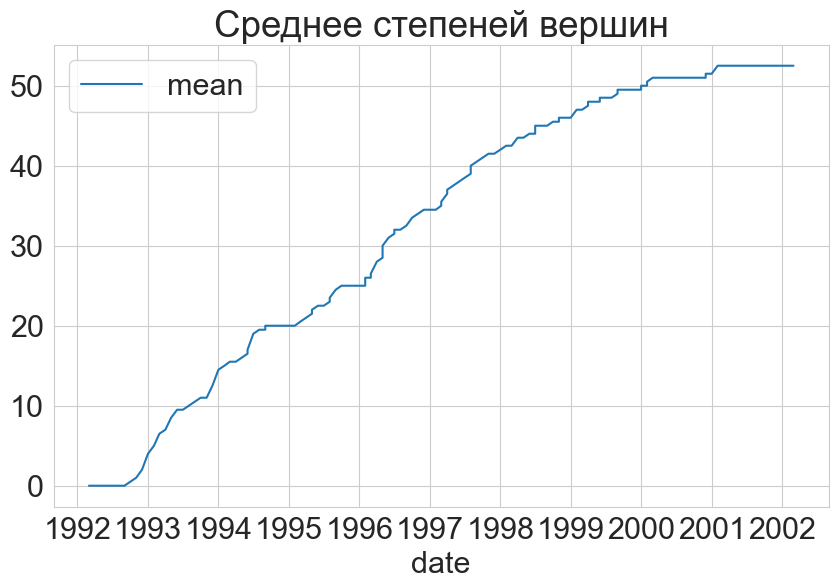

In [12]:
degrees_df[["date", "mean"]].drop_duplicates().plot(x="date", y="mean", title="Среднее степеней вершин")

<Axes: title={'center': 'Среднее степеней вершин'}, xlabel='date'>

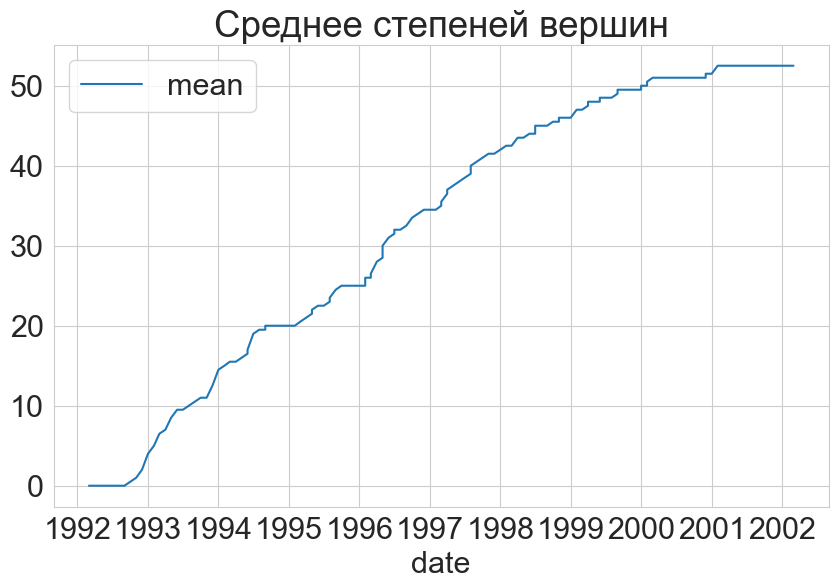

In [13]:
degrees_df[["date", "mean"]].drop_duplicates().plot(x="date", y="mean", title="Среднее степеней вершин")

<Axes: title={'center': 'Максимальное степеней вершин'}, xlabel='date'>

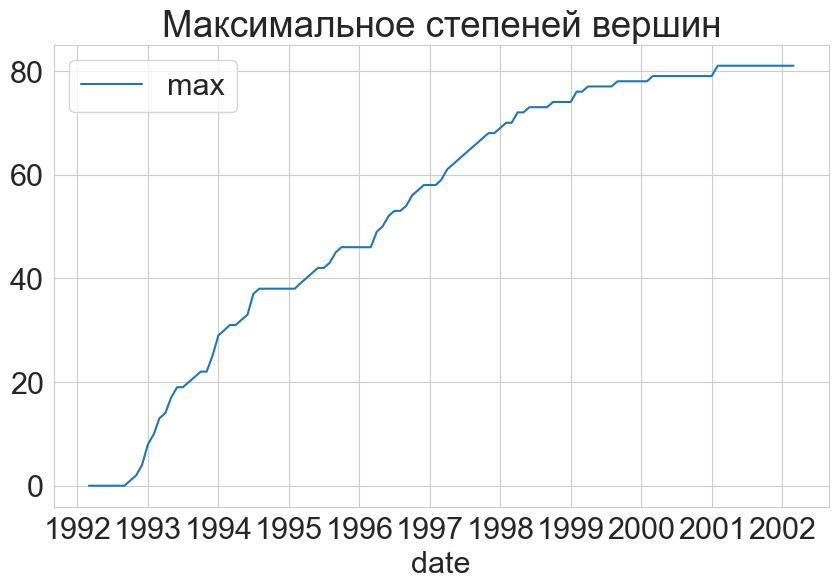

In [14]:
degrees_df[["date", "max"]].drop_duplicates().plot(x="date", y="max", title="Максимальное степеней вершин")

*  постройте зависимость $\pi (k)$ и аппроксимируйте ее степенной функцией. Можно ли считать, что сеть растет по принципу предпочтительного присоединения? Определите тип присоединения.

In [15]:
arr1 = degrees_df.query("node_id==9203201")["degree"][1:].values - degrees_df.query("node_id==9203201")["degree"][:-1].values
arr2 = degrees_df.query("node_id==9211202")["degree"][1:].values - degrees_df.query("node_id==9211202")["degree"][:-1].values

pi_k = arr1 + arr2
k = np.maximum(arr1, arr2)

In [16]:
k

array([0, 0, 0, 0, 0, 0, 1, 1, 2, 4, 2, 3, 1, 3, 2, 0, 1, 1, 1, 0, 3, 4,
       1, 1, 0, 1, 1, 4, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 2, 1, 0,
       0, 0, 2, 1, 3, 3, 2, 1, 0, 1, 2, 1, 1, 0, 0, 1, 2, 1, 1, 1, 2, 1,
       1, 1, 0, 1, 1, 0, 2, 0, 1, 2, 0, 0, 1, 1, 0, 0, 2, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

<Axes: >

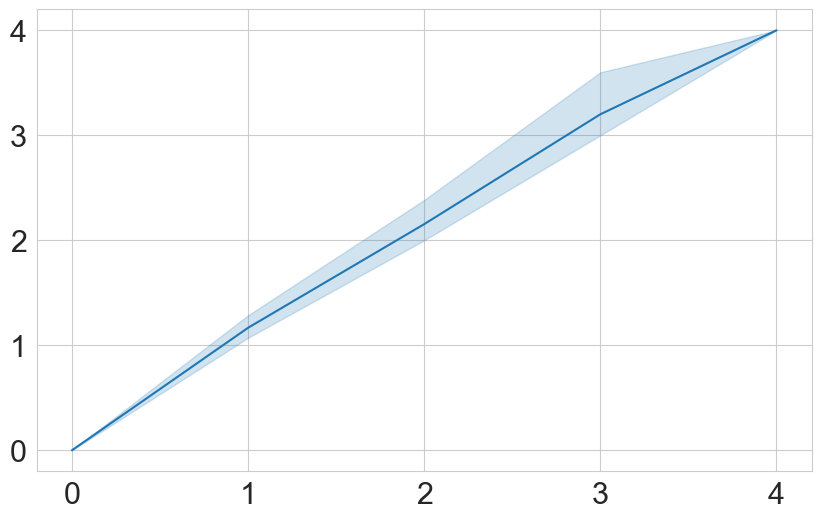

In [17]:
sns.lineplot(x=k, y=pi_k)

#### График линейный - тип присоединения является предпочтительным

## 2. Нелинейное предпочтительное присоединение (8 баллов)

* напишите генератор случайного графа, построенного по принципу нелинейного предпочтительного присоединения:
$$
\Pi(k_i) \sim k_i^{\alpha}
$$
* постройте зависимость степени вершины (например, выберите одну из затравочных, т.е. с индексом $i=0$) от времени (размера сети) для значений $\alpha=0.5,1.0,2.5$.

Рекомендуемые параметры: $m=4, t=[10^2,10^3,10^4,...]$.


* постройте распределение степеней вершин конечной сети и с помощью powerlaw определите наилучшую аппроксимацию степенным распределением, выведите параметры распределения.


In [18]:
class GraphGenerator:
    """
    Класс для генерации графа на основе предпочтительного присоединения.

    Атрибуты:
        num_steps (int): Количество шагов для генерации графа.
        num_edges (int): Количество рёбер, которые каждый новый узел формирует с существующими узлами.
        alpha (float): Экспонента, управляющая предпочтением присоединения к узлам с высокой степенью.
        graph (nx.Graph): Сгенерированный граф.
        edges_node_0 (List[int]): Список для хранения количества рёбер, подключенных к узлу 0 на каждом шаге.
        counter (int): Счетчик для отслеживания количества добавленных узлов в граф.
    """

    def __init__(self, num_steps: int, num_edges: int, alpha: float):
        """
        Инициализация Генератора Графа.

        Args:
            num_steps (int): Количество шагов для генерации графа.
            num_edges (int): Количество рёбер, которые каждый новый узел формирует с существующими узлами.
            alpha (float): Экспонента, управляющая предпочтением присоединения к узлам с высокой степенью.
        """
        self.graph: nx.Graph = nx.Graph()
        self.num_steps: int = num_steps
        self.num_edges: int = num_edges
        self.alpha: float = alpha
        self.__generate_graph()

    def __generate_graph(self) -> None:
        """
        Метод для генерации графа путём добавления узлов на num_steps шагов.
        """
        edges_node_0: List[int] = [] 
        counter = 0
        for _ in tqdm(range(self.num_steps)):
            self.graph.add_node(counter)
            nodes_to_connect = []
            if len(self.graph.nodes) > 1:
                p = np.array([len(self.graph.edges(x)) ** self.alpha for x in list(self.graph.nodes)[:-1]])
                if len(p) == 1:
                    p[0] = 1
                p = p.astype(float) / np.sum(p)
                nodes_to_connect = np.random.choice(
                    list(self.graph.nodes)[:-1], size=min(counter, self.num_edges), replace=False, p=p
                )
            for n in nodes_to_connect:
                self.graph.add_edge(counter, n)

            counter += 1
            edges_node_0.append(len(list(self.graph.edges(0))))
        self.edges_node_0 = edges_node_0

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

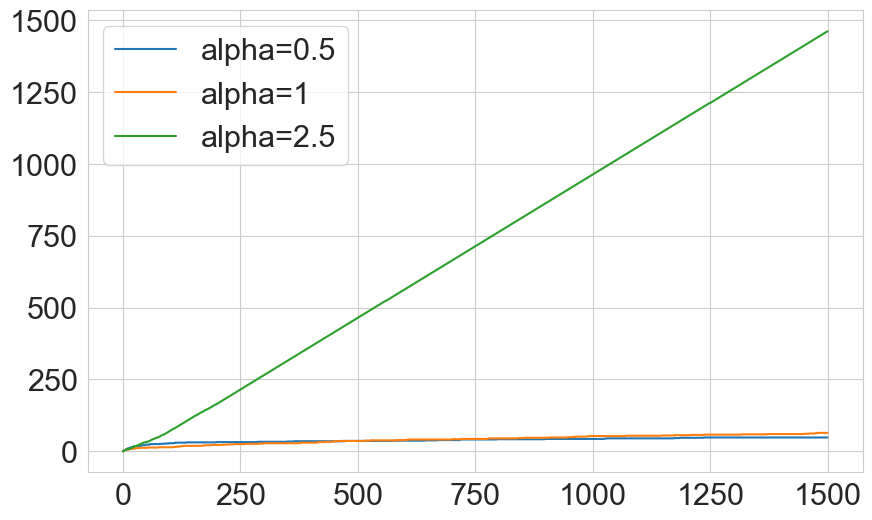

In [19]:
alphas = [0.5, 1, 2.5]
num_steps = 1500
num_edges = 4 

for alpha in (alphas):
    G = GraphGenerator(num_steps=num_steps, num_edges=num_edges, alpha=alpha)
    plt.plot(G.edges_node_0, label=f'alpha={alpha}')
plt.legend()


Alpha: 0.5



  0%|          | 0/1500 [00:00<?, ?it/s]

Calculating best minimal value for power law fit
4.101352777895396
15.0
Mean degree = 7.986666666666666

Alpha: 1



  0%|          | 0/1500 [00:00<?, ?it/s]

Calculating best minimal value for power law fit
2.6781300991477455
4.0
Mean degree = 7.986666666666666

Alpha: 2.5



  0%|          | 0/1500 [00:00<?, ?it/s]

Calculating best minimal value for power law fit
7.290922433860309
4.0
Mean degree = 7.986666666666666


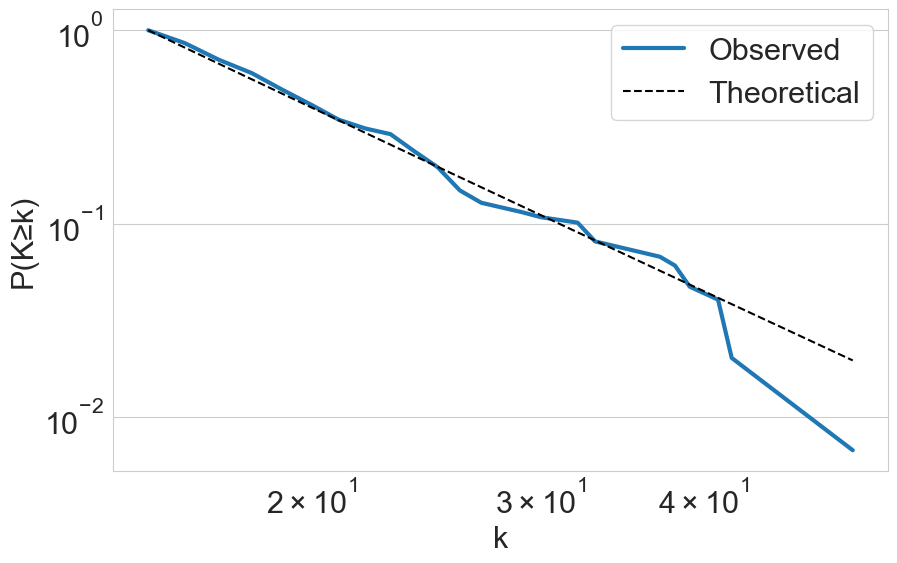

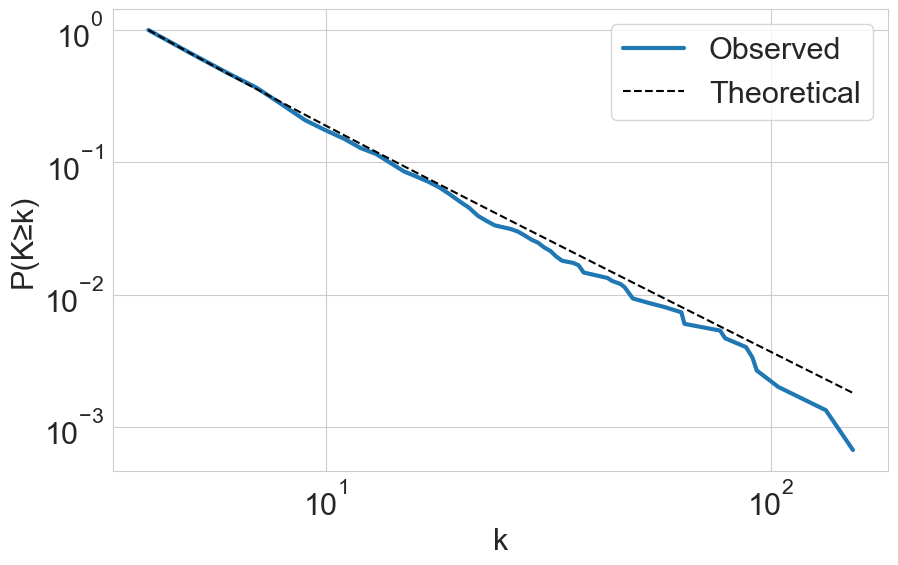

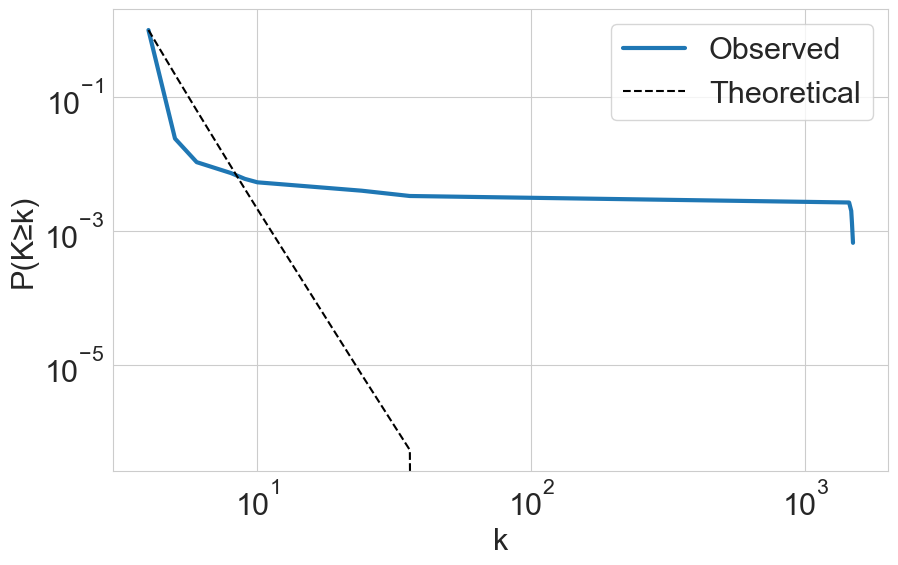

In [20]:
for alpha in alphas:
    print(f"\nAlpha: {alpha}\n")
    fig, ax = plt.subplots()
    G = GraphGenerator(num_steps=num_steps, num_edges=num_edges, alpha=alpha)
    node_degrees = list(dict(G.graph.degree()).values())
    fit_result = powerlaw.Fit(node_degrees, discrete=True)
    fit_result.plot_ccdf(ax=ax, linewidth=3, label='Observed')
    fit_result.power_law.plot_ccdf(ax=ax, color='k', linestyle='--', label='Theoretical')

    ax.set_ylabel(u"P(K≥k)")
    ax.set_xlabel("k")
    ax.legend()
    print(fit_result.power_law.alpha)
    print(fit_result.power_law.xmin)
    print(f'Mean degree = {np.mean(node_degrees)}')

##  3. Модель направленной сети с постоянной привлекательностью вершин и механизмом удаления (10 баллов)

*  напишите генератор случайной сети, где каждая новая вершина $l$ появляется с $m$ ребрами ($k_{out}=m$), а вероятность связи с вершинами сети определяется:
$$
P(l,i) =\frac{A+k_{i}^{in}}{\sum_j (A+k_{j}^{in})},
$$

A - постоянная привлекательность, принимает значения из $[0,100]$.
*  добавьте к генератору удаление случайно-выбранной вершины с коэффициентом $r$.

* исследуйте зависимость распределения входящих степеней от параметров $r,A$. Покажите существование двух режимов: степенное распределение степеней; затянутая экспонента в статистике степеней.

In [21]:
import numpy as np
import random
import matplotlib.pyplot as plt

class RandomNetworkGenerator:
    """
    Класс для генерации случайной сети.

    Attributes:
        num_nodes (int): Количество вершин в сети.
        m (int): Количество ребер, добавляемых к каждой новой вершине.
        A (float): Постоянная привлекательность, принимает значения из диапазона [0, 100].
        adj_matrix (np.ndarray): Матрица смежности сети.
        in_degree (np.ndarray): Массив, содержащий входящие степени вершин.
    """
    def __init__(self, num_nodes: int, m: int, A: float):
        """
        Инициализация генератора случайной сети.

        Args:
            num_nodes (int): Количество вершин в сети.
            m (int): Количество ребер, добавляемых к каждой новой вершине.
            A (float): Постоянная привлекательность, принимает значения из диапазона [0, 100].
        """
        self.num_nodes = num_nodes
        self.m = m
        self.A = A
        self.adj_matrix = np.zeros((num_nodes, num_nodes))
        self.in_degree = np.zeros(num_nodes)
        
    def add_node(self) -> None:
        """
        Добавляет новую вершину в сеть.
        """
        new_node_index = len(self.adj_matrix)
        self.adj_matrix = np.pad(self.adj_matrix, ((0, 1), (0, 1)), mode='constant')
        prob_connect = [(self.A + in_deg) / np.sum(self.A + self.in_degree) for in_deg in self.in_degree]
        for _ in range(self.m):
            connected_node_index = np.random.choice(range(len(prob_connect)), p=prob_connect)
            self.adj_matrix[new_node_index][connected_node_index] = 1
            self.in_degree[connected_node_index] += 1
        self.in_degree = np.append(self.in_degree, self.m)
        self.num_nodes += 1
        
    def remove_node(self, r: float) -> None:
        """
        Удаляет случайно выбранную вершину из сети с вероятностью r.

        Args:
            r (float): Вероятность удаления вершины.
        """
        if self.num_nodes == 0:
            return
        removed_node_index = np.random.randint(0, self.num_nodes)
        self.adj_matrix = np.delete(self.adj_matrix, removed_node_index, axis=0)
        self.adj_matrix = np.delete(self.adj_matrix, removed_node_index, axis=1)
        self.in_degree = np.delete(self.in_degree, removed_node_index)
        self.num_nodes -= 1
        for i in range(len(self.in_degree)):
            if random.random() < r:
                self.in_degree[i] -= 1 if self.in_degree[i] > 0 else 0
                
    def plot_in_degree_distribution(self) -> None:
        """
        Построение гистограммы распределения входящих степеней.
        """
        plt.hist(self.in_degree, bins=100)
        plt.xlabel('Входящая степень')
        plt.ylabel('Количество наблюдений')
        plt.title('Распределение входящих степеней')
        plt.show()

        
# Функция для генерации случайной сети и проведения эксперимента
def generate_random_network_and_experiment(num_steps: int, num_nodes: int, m: int, A: float, r: float) -> None:
    """
    Генерирует случайную сеть и проводит эксперимент по удалению вершин.

    Args:
        num_steps (int): Количество шагов
        num_nodes (int): Количество вершин в сети.
        m (int): Количество ребер, добавляемых к каждой новой вершине.
        A (float): Постоянная привлекательность, принимает значения из диапазона [0, 100].
        r (float): Коэффициент удаления вершины.
    """
    G = RandomNetworkGenerator(num_nodes, m, A)
    for _ in tqdm(range(num_steps)):
        G.add_node()
    G.remove_node(r)
    G.plot_in_degree_distribution()

Смотрим зависимость от коэффициента А

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

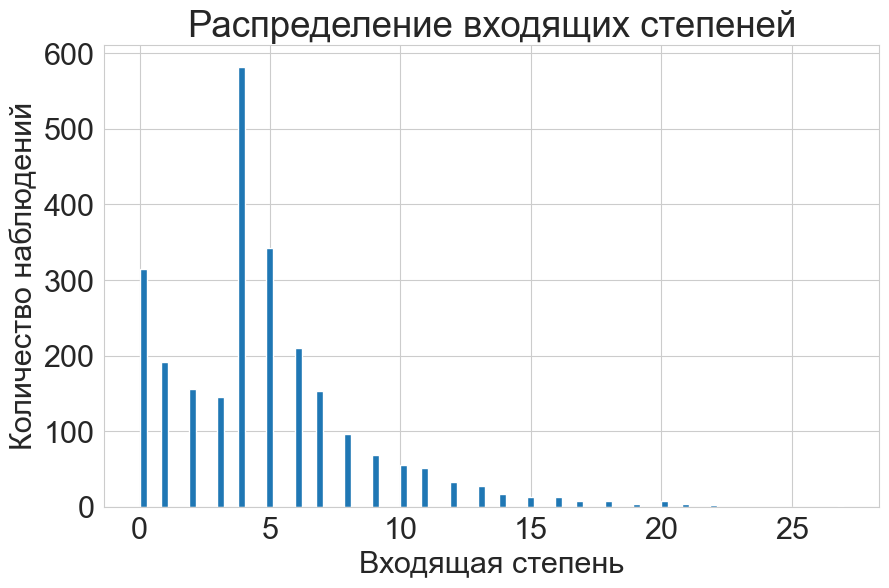

A = 1


  0%|          | 0/1500 [00:00<?, ?it/s]

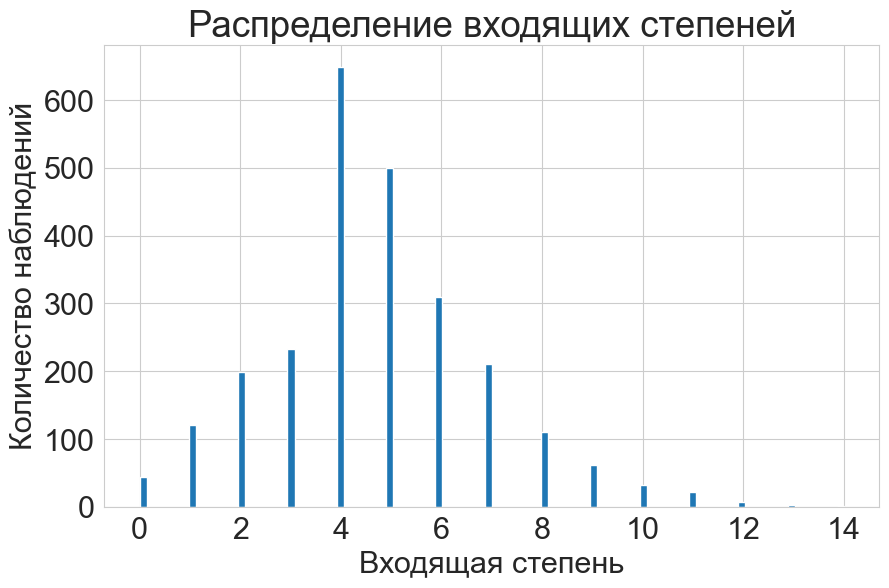

A = 20


  0%|          | 0/1500 [00:00<?, ?it/s]

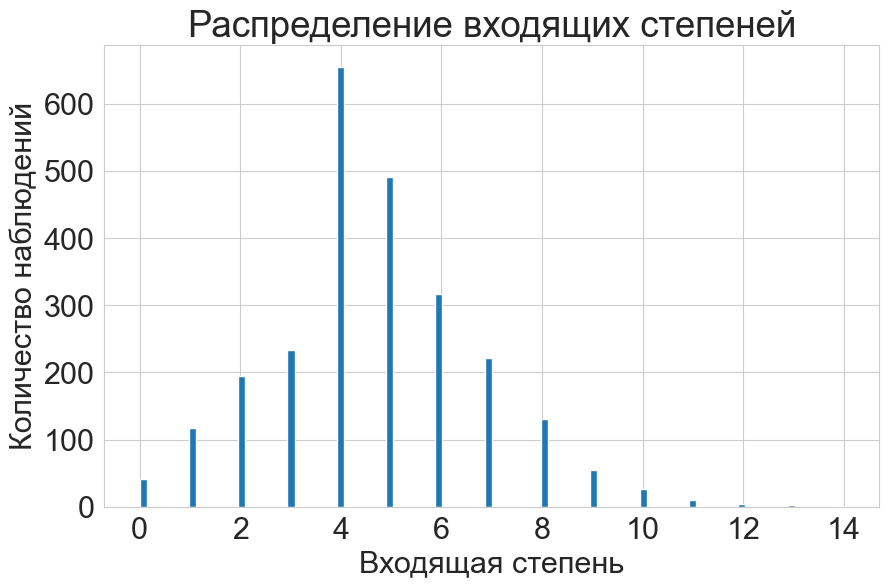

A = 50


  0%|          | 0/1500 [00:00<?, ?it/s]

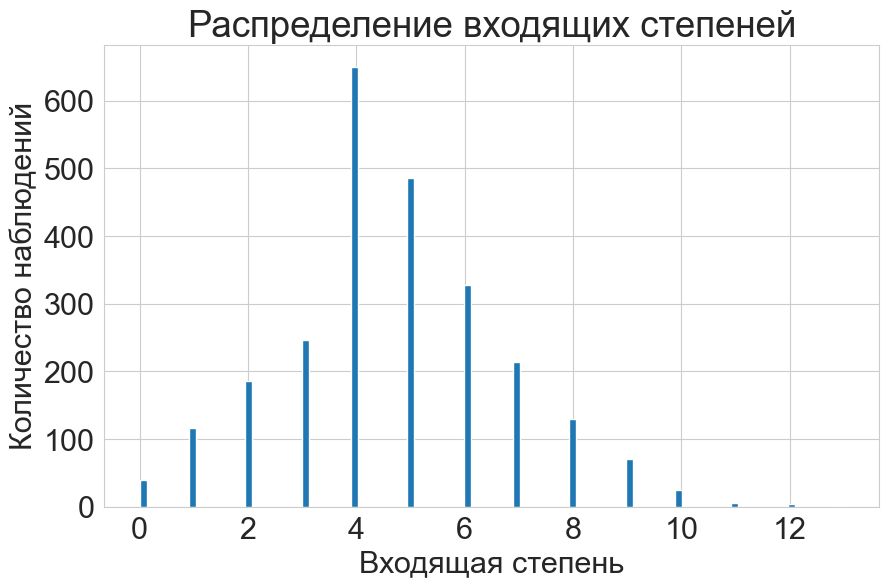

A = 100


In [22]:
for A in tqdm([1, 20, 50, 100]):
    generate_random_network_and_experiment(
        num_steps=num_steps, 
        num_nodes=1000, 
        m=4, 
        A=A,
        r=0.1
    )
    print(f"A = {A}")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

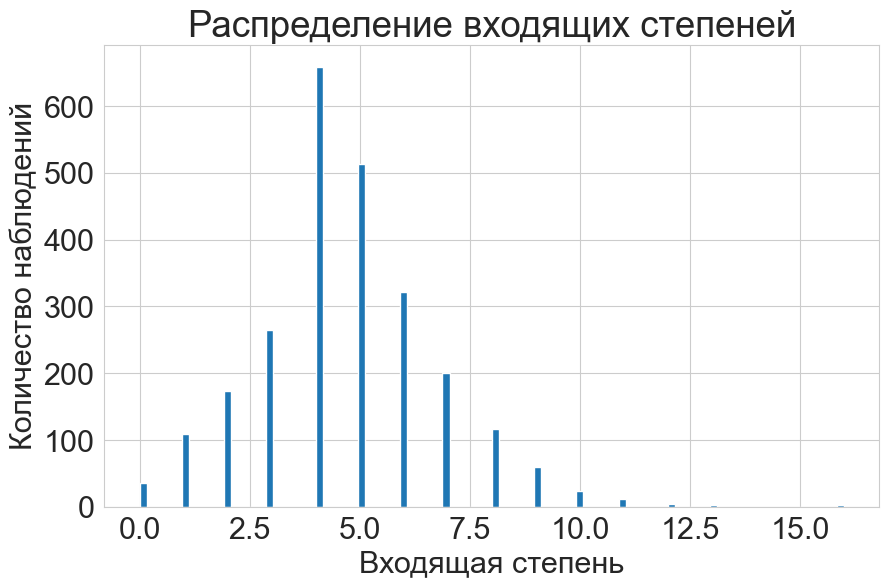

r = 0.1


  0%|          | 0/1500 [00:00<?, ?it/s]

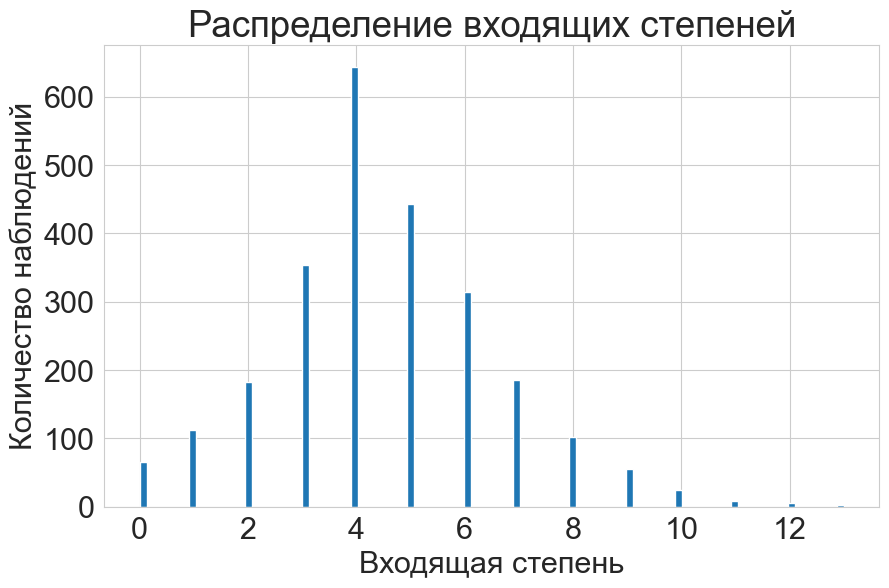

r = 0.3


  0%|          | 0/1500 [00:00<?, ?it/s]

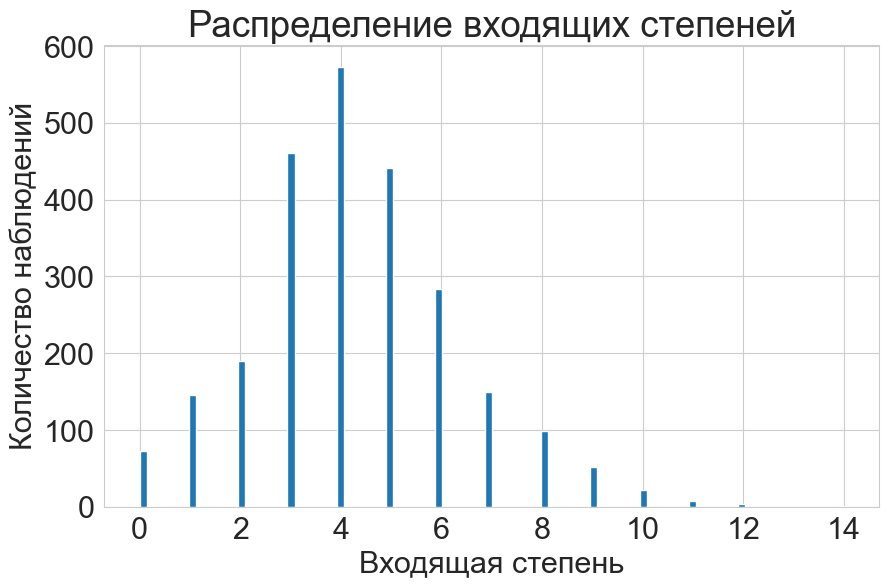

r = 0.5


  0%|          | 0/1500 [00:00<?, ?it/s]

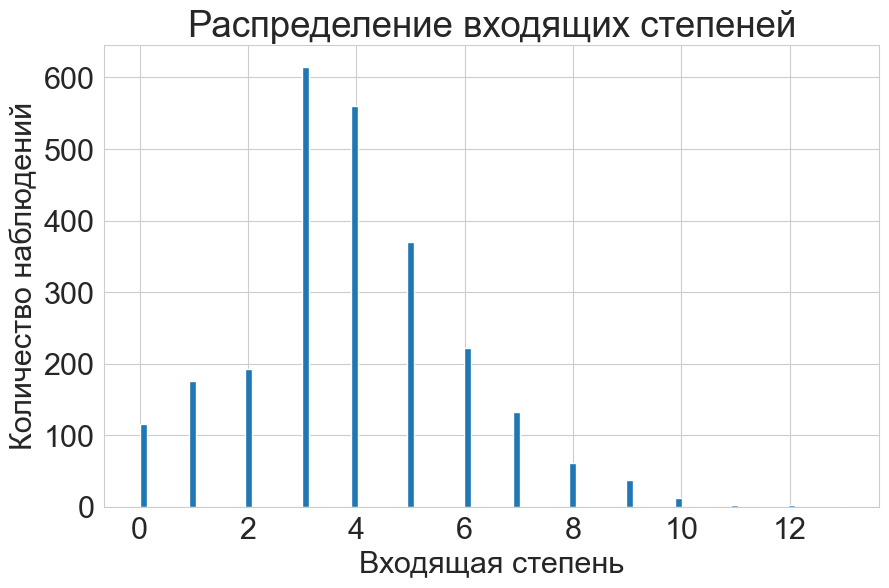

r = 0.9


In [23]:
for r in tqdm([0.1, 0.3, 0.5, 0.9]):
    generate_random_network_and_experiment(
        num_steps=num_steps, 
        num_nodes=1000, 
        m=4, 
        A=100,
        r=r
    )
    print(f"r = {r}")

## 4. Влияние топологии на характерное время распространение эпидемии в SI модели. (6 баллов)

* Сгенерируйте случайные графы из разных моделей: Эрдеша-Реньи, Барабаши-Альберта, Ваттса-Строгатца.

Число вершин всех графов $N=10^4$, а средняя степень у всех примерно одинакова и, например, $\left< k\right>\approx10$.

* Смоделируйте SI модель, изобразите на одном графике среднюю долю инфицированных от времени для разных графов.  

Параметры модели SI - $\beta$ и число шагов по времени - подберите самостоятельно.

На этом же графике изобразите кривую, отвечающую приближению среднего поля (из семинара).

* Видите ли вы отличия в распространении эпидемии? Объясните результаты.

In [24]:
def si_func(x0: float, beta_k: float, t: float) -> float:
    """
    Вычисляет значение сигмоидной функции в момент времени t.

    Параметры:
        x0 (float): Начальное значение функции.
        beta_k (float): Параметр скорости изменения функции.
        t (float): Значение времени, в которое требуется вычислить функцию.

    Возвращает:
        float: Значение сигмоидной функции в момент времени t.

    Формула:
        S(t) = x0 * exp(beta_k * t) / (1 - x0 + x0 * exp(beta_k * t))
    """
    return x0 * np.exp(beta_k * t) / (1 - x0 + x0 * np.exp(beta_k * t))


def simulate_si_graph(graph_type: nx.classes.graph.Graph, cfg, fraction_infected: float, num_steps: int) -> np.ndarray:
    """
    Симулирует распространение инфекции в модели SI на случайном графе Эрдеша-Реньи.

    Аргументы:
    graph_type (nx.classes.graph.Graph): тип графа
    cfg: конфигурация модели
    fraction_infected (float): Доля зараженных в начальном состоянии.
    er_graph (np.ndarray): Матрица смежности случайного графа Эрдеша-Реньи.
    cfg (dict): Начальное состояние узлов графа.
    N_iter (int): Количество итераций для моделирования.

    Возвращает:
    np.ndarray: Массив, содержащий начальную долю зараженных и долю зараженных после каждой итерации (в долях от 10000 узлов).

    Примечания:
    - Все узлы в начальном состоянии считаются подверженными инфекции.
    - Для моделирования используется структура SIModel из библиотеки ep.
    """
    si_graph = np.full(1, fraction_infected)  # Создание массива с начальной долей зараженных
    model = ep.SIModel(graph_type)  # Создание модели SI
    model.set_initial_status(cfg)  # Установка начального состояния узлов
    iterations = model.iteration_bunch(num_steps)  # Выполнение итераций моделирования
    infected_ratios = [node['node_count'][1] for node in iterations]  # Получение доли зараженных на каждой итерации
    nsi_graph_din = np.concatenate((si_graph, np.array(infected_ratios) / 10000))  # Объединение результатов
    return nsi_graph_din

In [25]:
beta = 0.01
fraction_infected = 0.01
n = 10000
k = 10
num_steps = 1000

erdos_renyi_graph = nx.erdos_renyi_graph(n, 0.001)
barabasi_albert_graph = nx.barabasi_albert_graph(n, k//2)
watts_strogatz_graph = nx.watts_strogatz_graph(n, k, 0.0)

cfg = mc.Configuration()
cfg.add_model_parameter("beta", beta)
cfg.add_model_parameter("fraction_infected", fraction_infected)

results = []

for graph_type in tqdm([erdos_renyi_graph, barabasi_albert_graph, watts_strogatz_graph]):
    result = simulate_si_graph(
        graph_type=graph_type,
        cfg=cfg,
        fraction_infected=fraction_infected,
        num_steps=num_steps
    )
    results.append(result)

  0%|          | 0/3 [00:00<?, ?it/s]

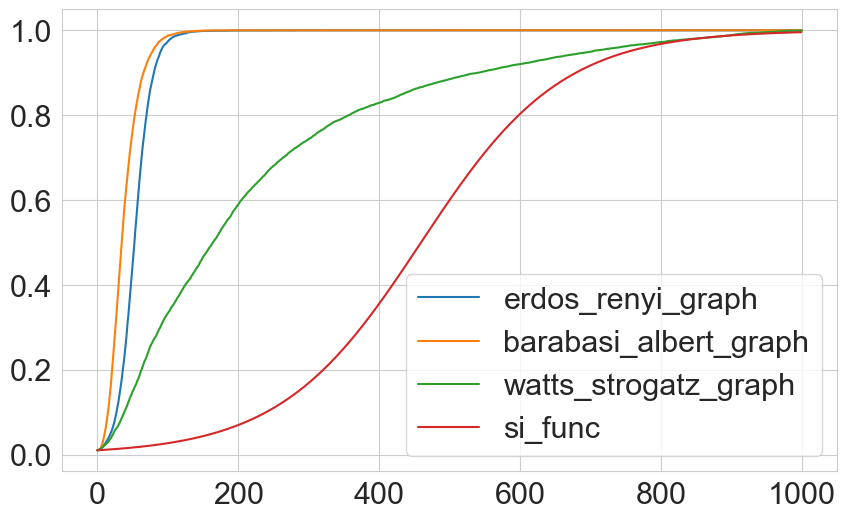

In [26]:
graph_names = ["erdos_renyi_graph", "barabasi_albert_graph", "watts_strogatz_graph"]

for graph_result, graph_name in zip(results, graph_names):
    plt.plot(graph_result, label=graph_name)

t = np.linspace(0, num_steps - 1, num_steps)
plt.plot(si_func(fraction_infected, beta, t), label='si_func')
plt.legend()

plt.show()

Видите ли вы отличия в распространении эпидемии? Объясните результаты.  
**Эпидемия быстрее распространяется в графах с большей связанностью**

## 5. SIR на сетях различной топологии (6 баллов)
Рассмотрим модель SIR на следующих сетях:

In [27]:
load_url_content_to_file(
    url="https://drive.google.com/uc?id=13hlp2ZU0idFzJR-8RXGO4FOp4OI8y6Uo",
    filename = "graph1.graphml"
)

In [28]:
load_url_content_to_file(
    url="https://drive.google.com/uc?id=1xkAOK6sp8PsUFKGea2G-oQd8JGDF_Qgh",
    filename = "graph2.graphml"
)

In [29]:
G1=nx.read_graphml('graph1.graphml')
G2=nx.read_graphml('graph2.graphml')

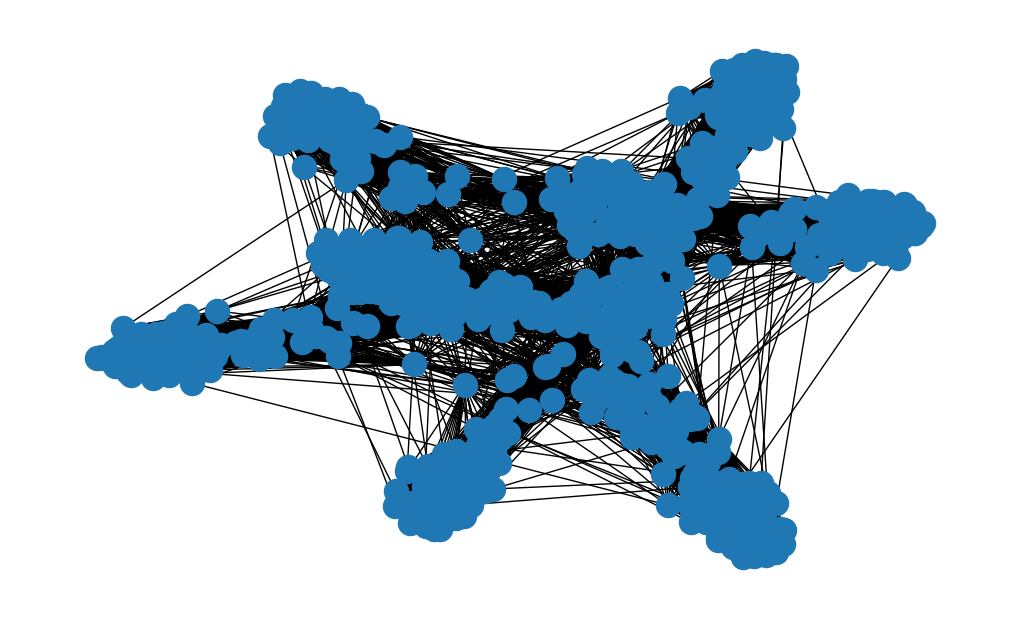

In [30]:
nx.draw(G1)

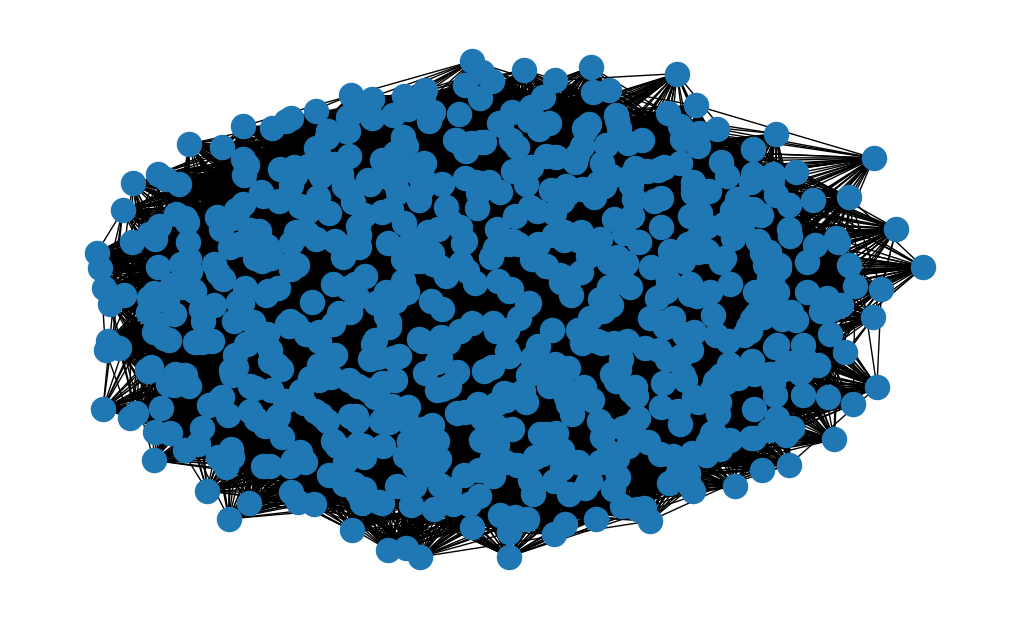

In [31]:
nx.draw(G2)

#### Видно, что граф 1 имеет обособленный элементы, в отличие от графа 2

* Постройте зависимости средней доли зараженных вершин в модели SIR для первого и второго графа.

Параметры для моделирования:

In [32]:
beta=0.005
gamma=0.03
percentage_infected=0.002
n_iter=200 # число шагов моделирования
n_run=100 # число запусков распространения для усреднения

* Отличаются ли построенные зависимости?
Попробуйте понять, что влияет на распространение в сети, для этого исследуйте топологию G1, G2.

* Поменяйте параметры модели, всегда ли распространение "чувствительно" к топологии сети?

In [33]:
cfg = mc.Configuration()
cfg.add_model_parameter("beta", beta)
cfg.add_model_parameter("gamma", gamma)
cfg.add_model_parameter("fraction_infected", percentage_infected)

In [34]:
model1 = ep.SIRModel(G1)
model2 = ep.SIRModel(G2)
model1.set_initial_status(cfg)
model2.set_initial_status(cfg)

iterations1 = model1.iteration_bunch(n_iter)
iterations2 = model2.iteration_bunch(n_iter)

In [35]:
nodes_count_1 = np.array([list(node['node_count'].values())[:3] for node in iterations1[1:]])
nodes_count_2 = np.array([list(node['node_count'].values())[:3] for node in iterations2[1:]])

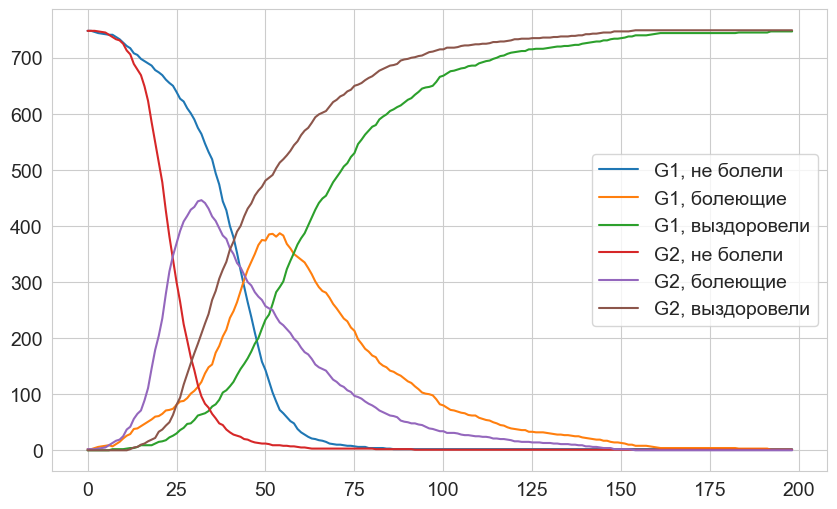

In [42]:
# Графики для G1
plt.plot(nodes_count_1[:, 0], label='G1, не болели')
plt.plot(nodes_count_1[:, 1], label='G1, болеющие')
plt.plot(nodes_count_1[:, 2], label='G1, выздоровели')

# Графики для G2
plt.plot(nodes_count_2[:, 0], label='G2, не болели')
plt.plot(nodes_count_2[:, 1], label='G2, болеющие')
plt.plot(nodes_count_2[:, 2], label='G2, выздоровели')

plt.legend() 

## Граф 1

### смотрим на изменения бета

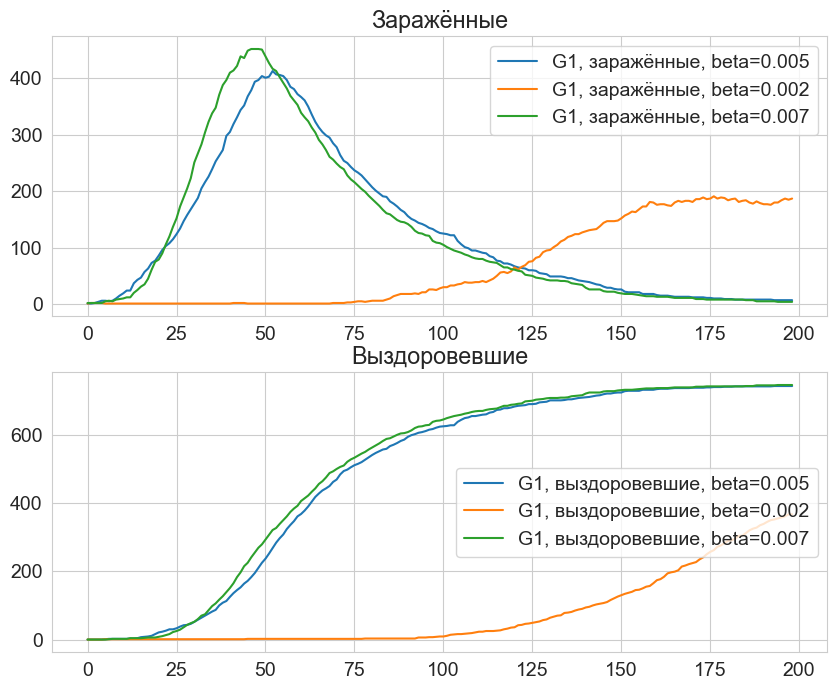

In [37]:
plt.rcParams["font.size"] = 14

fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # Creating two subplots

for beta in [0.005, 0.002, 0.007]:
    cfg = mc.Configuration()
    cfg.add_model_parameter("beta", beta)
    cfg.add_model_parameter("gamma", gamma)
    cfg.add_model_parameter("fraction_infected", percentage_infected)
    model1 = ep.SIRModel(G1)
    model1.set_initial_status(cfg)
    iterations1 = model1.iteration_bunch(n_iter)
    nodes_count_1 = np.array([list(node['node_count'].values())[:3] for node in iterations1[1:]])
    
    # Plotting for the first subplot (infected individuals)
    axes[0].plot(nodes_count_1[:, 1], label=f'G1, заражённые, beta={beta}')
    
    # Plotting for the second subplot (recovered individuals)
    axes[1].plot(nodes_count_1[:, 2], label=f'G1, выздоровевшие, beta={beta}')

# Setting titles and legends
axes[0].set_title('Заражённые')
axes[0].legend()
axes[1].set_title('Выздоровевшие')
axes[1].legend() 

### смотрим на изменения гамма

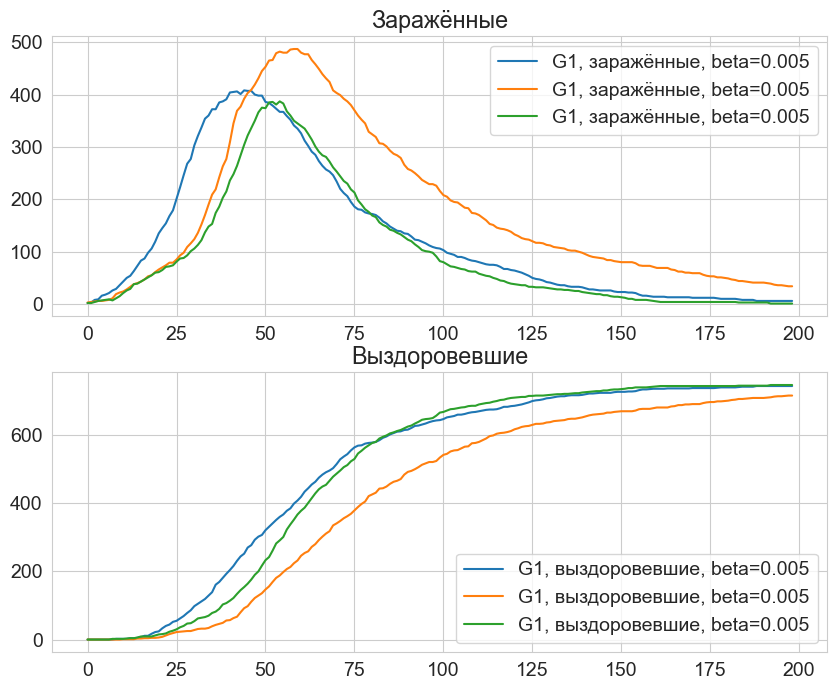

In [38]:
plt.rcParams["font.size"] = 14

beta=0.005
fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # Creating two subplots

for gamma in [0.03, 0.02, 0.04]:
    cfg = mc.Configuration()
    cfg.add_model_parameter("beta", beta)
    cfg.add_model_parameter("gamma", gamma)
    cfg.add_model_parameter("fraction_infected", percentage_infected)
    model1 = ep.SIRModel(G1)
    model1.set_initial_status(cfg)
    iterations1 = model1.iteration_bunch(n_iter)
    nodes_count_1 = np.array([list(node['node_count'].values())[:3] for node in iterations1[1:]])
    
    # Plotting for the first subplot (infected individuals)
    axes[0].plot(nodes_count_1[:, 1], label=f'G1, заражённые, beta={beta}')
    
    # Plotting for the second subplot (recovered individuals)
    axes[1].plot(nodes_count_1[:, 2], label=f'G1, выздоровевшие, beta={beta}')

# Setting titles and legends
axes[0].set_title('Заражённые')
axes[0].legend()
axes[1].set_title('Выздоровевшие')
axes[1].legend() 

## Граф 2

### смотрим на изменения бета

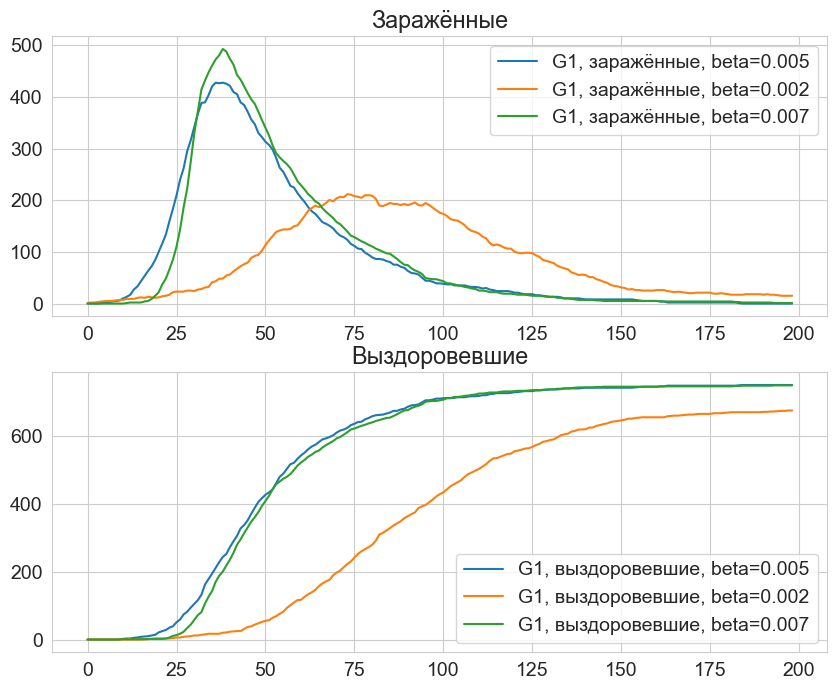

In [39]:
plt.rcParams["font.size"] = 14

fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # Creating two subplots

for beta in [0.005, 0.002, 0.007]:
    cfg = mc.Configuration()
    cfg.add_model_parameter("beta", beta)
    cfg.add_model_parameter("gamma", gamma)
    cfg.add_model_parameter("fraction_infected", percentage_infected)
    model2 = ep.SIRModel(G2)
    model2.set_initial_status(cfg)
    iterations2 = model2.iteration_bunch(n_iter)
    nodes_count_2 = np.array([list(node['node_count'].values())[:3] for node in iterations2[1:]])
    
    # Plotting for the first subplot (infected individuals)
    axes[0].plot(nodes_count_2[:, 1], label=f'G1, заражённые, beta={beta}')
    
    # Plotting for the second subplot (recovered individuals)
    axes[1].plot(nodes_count_2[:, 2], label=f'G1, выздоровевшие, beta={beta}')

# Setting titles and legends
axes[0].set_title('Заражённые')
axes[0].legend()
axes[1].set_title('Выздоровевшие')
axes[1].legend() 

### смотрим на изменения гамма

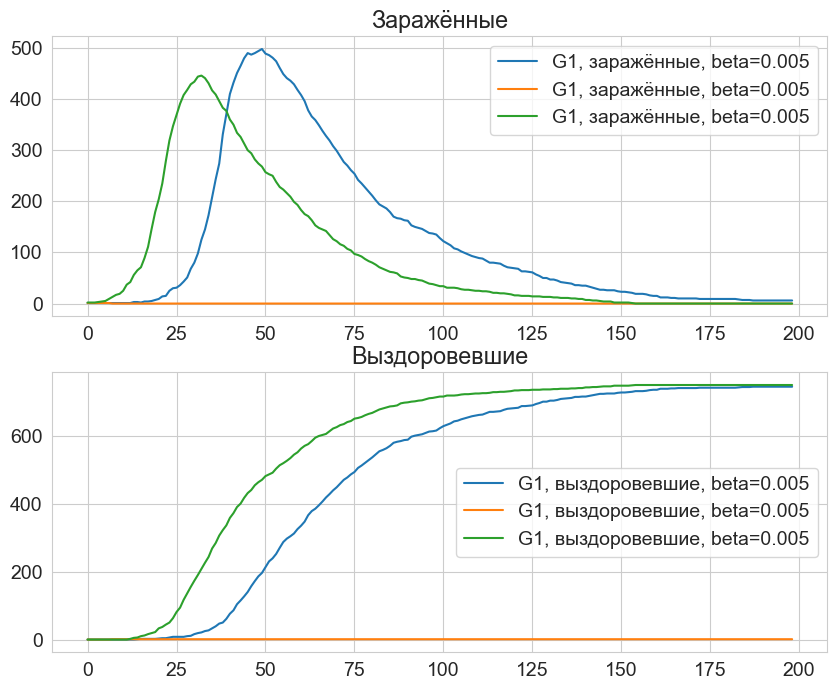

In [40]:
plt.rcParams["font.size"] = 14

beta=0.005
fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # Creating two subplots

for gamma in [0.03, 0.02, 0.04]:
    cfg = mc.Configuration()
    cfg.add_model_parameter("beta", beta)
    cfg.add_model_parameter("gamma", gamma)
    cfg.add_model_parameter("fraction_infected", percentage_infected)
    model2 = ep.SIRModel(G2)
    model2.set_initial_status(cfg)
    iterations2 = model2.iteration_bunch(n_iter)
    nodes_count_2 = np.array([list(node['node_count'].values())[:3] for node in iterations2[1:]])
    
    # Plotting for the first subplot (infected individuals)
    axes[0].plot(nodes_count_2[:, 1], label=f'G1, заражённые, beta={beta}')
    
    # Plotting for the second subplot (recovered individuals)
    axes[1].plot(nodes_count_2[:, 2], label=f'G1, выздоровевшие, beta={beta}')

# Setting titles and legends
axes[0].set_title('Заражённые')
axes[0].legend()
axes[1].set_title('Выздоровевшие')
axes[1].legend() 

## Вывод

Поменяйте параметры модели, всегда ли распространение "чувствительно" к топологии сети?  
**Кроме распространение влияет ещё и вероятности заболевание/выздоровления**